<a href="https://colab.research.google.com/github/Sharvin03/LAB_7_SE/blob/main/Temp_Pred.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import Dataset

In [ ]:
import pandas as pd

import numpy as np

features = pd.read_csv('/content/temps.csv')
features.head(5)

,year,month,day,week,temp_2,temp_1,average,actual,forecast_noaa,forecast_acc,forecast_under,friend
0,2016,1,1,Fri,45,45,45.6,45,43,50,44,29
1,2016,1,2,Sat,44,45,45.7,44,41,50,44,61
2,2016,1,3,Sun,45,44,45.8,41,43,46,47,56
3,2016,1,4,Mon,44,41,45.9,40,44,48,46,53
4,2016,1,5,Tues,41,40,46.0,44,46,46,46,41


In [ ]:
features.year.value_counts()

year
2016    348
Name: count, dtype: int64

Check for any missing values

In [ ]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 348 entries, 0 to 347
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   year            348 non-null    int64  
 1   month           348 non-null    int64  
 2   day             348 non-null    int64  
 3   week            348 non-null    object 
 4   temp_2          348 non-null    int64  
 5   temp_1          348 non-null    int64  
 6   average         348 non-null    float64
 7   actual          348 non-null    int64  
 8   forecast_noaa   348 non-null    int64  
 9   forecast_acc    348 non-null    int64  
 10  forecast_under  348 non-null    int64  
 11  friend          348 non-null    int64  
dtypes: float64(1), int64(10), object(1)
memory usage: 32.8+ KB


Perform one hot encoding

In [ ]:
features = pd.get_dummies(features)
features.head(5)

,year,month,day,temp_2,temp_1,average,actual,forecast_noaa,forecast_acc,forecast_under,friend,week_Fri,week_Mon,week_Sat,week_Sun,week_Thurs,week_Tues,week_Wed
0,2016,1,1,45,45,45.6,45,43,50,44,29,True,False,False,False,False,False,False
1,2016,1,2,44,45,45.7,44,41,50,44,61,False,False,True,False,False,False,False
2,2016,1,3,45,44,45.8,41,43,46,47,56,False,False,False,True,False,False,False
3,2016,1,4,44,41,45.9,40,44,48,46,53,False,True,False,False,False,False,False
4,2016,1,5,41,40,46.0,44,46,46,46,41,False,False,False,False,False,True,False


In [ ]:
features.shape

(348, 18)

In [ ]:
features = features.drop('forecast_noaa', axis=1)
features = features.drop('forecast_acc', axis=1)
features = features.drop('forecast_under', axis=1)

In [ ]:
features.shape

(348, 15)

Split the features and labels, and store in array

In [ ]:
import numpy as np

labels = np.array(features['actual'])
features = features.drop('actual', axis=1)

features_list = list(features.columns)
features = np.array(features)

In [ ]:
from sklearn.model_selection import train_test_split
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 42)

In [ ]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (261, 14)
Training Labels Shape: (261,)
Testing Features Shape: (87, 14)
Testing Labels Shape: (87,)


So far:

1. One-hot encoded categorical variables
2. Split data into features and labels
3. Converted to arrays
4. Split data into training and testing sets

In [ ]:
baseline_preds = test_features[:, features_list.index('average')]
baseline_errors = abs(baseline_preds - test_labels)
print('Average baseline error: ', round(np.mean(baseline_errors), 2))

Average baseline error:  5.06


In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
rf.fit(train_features, train_labels)

RandomForestRegressor(n_estimators=1000, random_state=42)

In [ ]:
predictions = rf.predict(test_features)
errors = abs(predictions - test_labels)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error: 3.83 degrees.


In [ ]:
mape = 100 * (errors / test_labels)# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 93.98 %.


Code for Visualizing a Tree

In [ ]:
from sklearn.tree import export_graphviz
import pydot# Pull out one tree from the forest
tree = rf.estimators_[5]# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot# Pull out one tree from the forest
tree = rf.estimators_[5]# Export the image to a dot file
export_graphviz(tree, out_file = 'tree.dot', feature_names = features_list, rounded = True, precision = 1)# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('tree.dot')# Write graph to a png file
graph.write_png('tree.png')

In [ ]:
# Limit depth of tree to 3 levels
rf_small = RandomForestRegressor(n_estimators=10, max_depth = 3)
rf_small.fit(train_features, train_labels)# Extract the small tree
tree_small = rf_small.estimators_[5]# Save the tree as a png image
export_graphviz(tree_small, out_file = 'small_tree.dot', feature_names = features_list, rounded = True, precision = 1)
(graph, ) = pydot.graph_from_dot_file('small_tree.dot')
graph.write_png('small_tree.png');

Listing importance of variables

In [ ]:
importances = list(rf.feature_importances_)# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(features_list, importances)]# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)# Print out the feature and importances
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: temp_1               Importance: 0.69
Variable: average              Importance: 0.2
Variable: day                  Importance: 0.03
Variable: friend               Importance: 0.03
Variable: temp_2               Importance: 0.02
Variable: month                Importance: 0.01
Variable: year                 Importance: 0.0
Variable: week_Fri             Importance: 0.0
Variable: week_Mon             Importance: 0.0
Variable: week_Sat             Importance: 0.0
Variable: week_Sun             Importance: 0.0
Variable: week_Thurs           Importance: 0.0
Variable: week_Tues            Importance: 0.0
Variable: week_Wed             Importance: 0.0


In [ ]:
rf_most_important = RandomForestRegressor(n_estimators= 1000, random_state=42)# Extract the two most important features
important_indices = [features_list.index('temp_1'), features_list.index('average')]
train_important = train_features[:, important_indices]
test_important = test_features[:, important_indices]# Train the random forest
rf_most_important.fit(train_important, train_labels)# Make predictions and determine the error
predictions = rf_most_important.predict(test_important)
errors = abs(predictions - test_labels)# Display the performance metrics
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')
mape = np.mean(100 * (errors / test_labels))
accuracy = 100 - mape
print('Accuracy:', round(accuracy, 2), '%.')

Mean Absolute Error: 3.92 degrees.
Accuracy: 93.76 %.


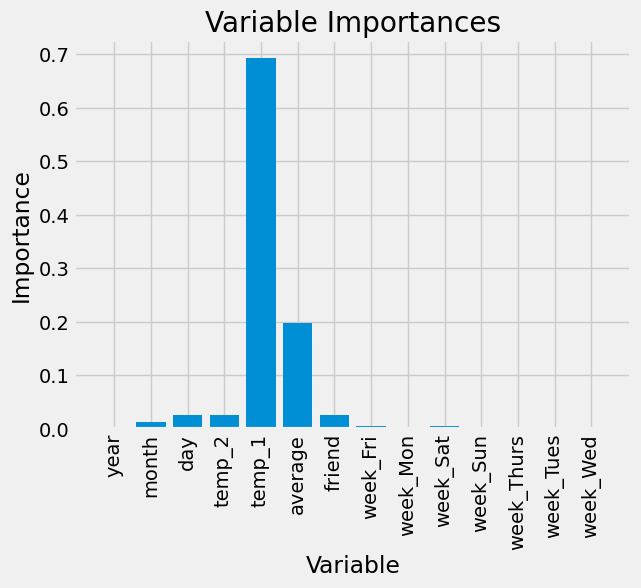

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')# list of x locations for plotting
x_values = list(range(len(importances)))# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')# Tick labels for x axis
plt.xticks(x_values, features_list, rotation='vertical')# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');



In [ ]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(random_state=42)
from pprint import pprint
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [ ]:
from sklearn.model_selection import RandomizedSearchCV# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation,
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)# Fit the random search model
rf_random.fit(train_features, train_labels)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [ ]:
rf_random.best_params_

{'n_estimators': 200,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 50,
 'bootstrap': True}

To determine if random search yielded a better model, we compare the base model with the best random search model.

In [ ]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))

    return accuracy
base_model = RandomForestRegressor(n_estimators = 10, random_state = 42)
base_model.fit(train_features, train_labels)
base_accuracy = evaluate(base_model, test_features, test_labels)

Model Performance
Average Error: 4.3092 degrees.
Accuracy = 93.24%.


In [ ]:
best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, test_features, test_labels)

Model Performance
Average Error: 3.8547 degrees.
Accuracy = 94.01%.


In [ ]:
print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

Improvement of 0.82%.


Random search allowed us to narrow down the range for each hyperparameter. Now that we know where to concentrate our search, we can explicitly specify every combination of settings to try. We do this with GridSearchCV

In [ ]:
from sklearn.model_selection import GridSearchCV# Create the parameter grid based on the results of random search
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}# Create a based model
rf = RandomForestRegressor()# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid,
                          cv = 3, n_jobs = -1, verbose = 2)

This will try out 1 * 4 * 2 * 3 * 3 * 4 = 288 combinations of settings.

In [ ]:
grid_search.fit(train_features, train_labels)
grid_search.best_params_

Fitting 3 folds for each of 288 candidates, totalling 864 fits


{'bootstrap': True,
 'max_depth': 80,
 'max_features': 3,
 'min_samples_leaf': 4,
 'min_samples_split': 8,
 'n_estimators': 100}

In [ ]:
best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, test_features, test_labels)

Model Performance
Average Error: 3.6836 degrees.
Accuracy = 94.28%.


In [ ]:
print('Improvement of {:0.2f}%.'.format( 100 * (grid_accuracy - base_accuracy) / base_accuracy))

Improvement of 1.11%.
